# Programming Assignment: EMNIST Letter Detective

You’ve already trained a neural network to recognize handwritten digits using the MNIST dataset. That gave you a clean, structured environment to get familiar with image classification.

Now it’s time for something more challenging. 
You’re going to apply those same skills to a new dataset: EMNIST. It contains handwritten **letters** instead of digits. The data is messier and more varied, and there are 26 classes instead of 10, so your model will need to work a little harder to get things right.

At the end of the lab, you’ll put your trained model to the test by decoding a handwritten message from Andrew Ng.


**What You'll Do in This Assignment**

* Load and explore the EMNIST Letters dataset to understand its structure and contents

* Preprocess the images by fixing their orientation, normalizing pixel values, and converting them to tensors

* Build a multi-layer neural network that can classify handwritten letters

* Train and evaluate your model on unseen examples

* Use your trained model to decode a secret handwritten message

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#imports)
- [1. Letter Images](#1)
  - [1.1 Load the Dataset](#1.1)
  - [1.2 Explore the Raw Data](#1.2)
  - [1.3 Preprocessing the Images](#1.3)
  - [1.4 Loading Data in Batches](#1.4)
    - **[Exercise 1 - create_emnist_dataloaders](#ex1)**   
- [2. Building the Neural Network](#2)
  - **[Exercise 2 - initialize_emnist_model](#ex2)**
- [3. Training and Evaluation of the Model](#3)
    - [3.1 Training the Model](#3.1)
        - **[Exercise 3 - train_epoch](#ex3)**
    - [3.2 Evaluation of the Model](#3.2)
        - **[Exercise 4 - evaluate](#ex4)**
    - [3.3 Putting it all together](#3.3)
        - **[Exercise 5 - train_and_evaluate](#ex5)**
- [4. Decoding the Secret Message](#4)

<a name='imports'></a>
## Imports

In [1]:
import os
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torchvision.transforms.functional as F

In [2]:
import helper_utils
import unittests

Check to see if the `DEVICE` available is "cuda" or "cpu"

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cpu


<a name='1'></a>
## 1 - Letter Images

You’ll start by loading the EMNIST dataset, focusing on the **Letters** subset.
It extends MNIST by providing handwritten **letters** instead of digits.
This subset includes **124,800 grayscale images** for training and **20,800 images** for testing, each labeled with one of **26 lowercase letter classes**.

<a name='1.1'></a>
### 1.1 - Load the Dataset

Before you can work with the EMNIST Letters data, you'll need to make sure it’s available in your workspace.
If it’s not already there, you can download it using `torchvision.datasets.EMNIST`.
You’ll be using the `letters` split of the EMNIST dataset, which includes handwritten characters from 'a' through 'z'.
To select this subset, make sure to pass `split='letters'` to the `EMNIST` constructor.

In [4]:
# Define the path where the EMNIST data will be stored
data_path = './EMNIST_data'

# Check if the data folder exists to avoid re-downloading
if os.path.exists(data_path) and os.path.isdir(data_path):
    download = False
    print("EMNIST Data folder found locally. Loading from local.\n")
else:
    download = True
    print("EMNIST Data folder not found locally. Downloading data.\n")


# Load the EMNIST Letters training set
train_dataset = datasets.EMNIST(
    root=data_path,  # Specify the root directory for the dataset
    split='letters',  # Use the 'letters' subset (26 lowercase classes)
    train=True,  # Indicate that this is the training set
    download=download  # Download the dataset if needed (based on the previous check)
)

test_dataset = datasets.EMNIST(
    root=data_path,  # Specify the root directory for the dataset
    split='letters',  # Use the 'letters' subset (26 lowercase classes)
    train=False,  # Indicate that this is the test set
    download=download  # Download the dataset if needed (based on the previous check)
)

EMNIST Data folder not found locally. Downloading data.



100.0%


<a name='1.2'></a>
### 1.2 - Explore the Raw Data

Now that your dataset is loaded, take a moment to see what you’re working with. Visualizing a few samples will help you understand how the letters are written and what challenges your model might face.

Start by displaying a sample image using `helper_utils.visualize_image`. 
Then, try changing the index value to view different examples.

As you explore, consider:
* Do these letters look the way you’d expect?
* Is there anything about their appearance that might make training or interpretation harder?

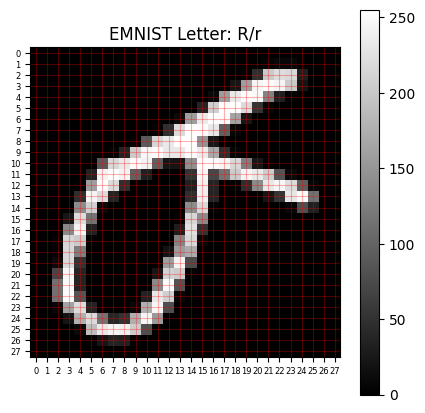


 Image type: <class 'PIL.Image.Image'>


In [5]:
index = 90000  # Pick an index from the training set

img, label = train_dataset[index]  # Extract the image and its label

helper_utils.visualize_image(img, label)  # Display the image with its label

# The image is stored as a PIL Image object. You'll convert it to a tensor before training.
print(f"\n Image type: {type(img)}")

You’ll probably notice that the handwritten letters appear rotated or flipped. Technically, a model can still learn from them as long as **every image is oriented the same way**. The model doesn’t “know” what properly oriented letter looks like; it just learns patterns that are consistent across the dataset.

However, this can make it harder for *you* to visually inspect or interpret the samples.
In the next step, you’ll use a helper function to display the letters in a more familiar orientation so they’re easier to look at. This correction is only for visualization. The underlying data will remain unchanged, and the model will still train on it exactly as provided.

<a name='1.3'></a>
### 1.3 - Preprocessing the Images

Before you can train your model, you need to convert the images into a format that PyTorch can work with, and apply normalization to help the model learn more effectively.

To do this, you’ll use `transforms.Compose` to apply a sequence of preprocessing steps: 
* `transforms.ToTensor()` converts the image from a PIL format to a PyTorch tensor.
* `transforms.Normalize(mean, std)` scales pixel values using precomputed mean and standard deviation values.

Normalization keeps pixel values within a consistent range, which improves numerical stability and helps your model train faster and more reliably.

These transformations are applied automatically **each time a sample is loaded from the dataset**, ensuring that all data passed to the model is standardized and ready for training or evaluation.

In [6]:
# Precomputed mean and std for EMNIST Letters dataset
mean = (0.1736,)
std = (0.3317,)

# Create a transform that converts images to tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    transforms.Normalize(mean=mean, std=std)   # Applies normalization using the computed mean and std
])

# Assign the transform to both the training and test datasets
train_dataset.transform = transform
test_dataset.transform = transform

Now take another look at the same sample. 
This time, you’re seeing the raw tensor after the transformations were applied.

In [7]:
# Set the index of the sample image to view
index = 90000

# Retrieve the transformed image tensor and its label from the training set
img_tensor, label = train_dataset[index]

# Print the image tensor to see the raw values (after transformation)
print(img_tensor)

tensor([[[-0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234],
         [-0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.4761, -0.4288, -0.4288, -0.5234, -0.5234, -0.5234, -0.5234],
         [-0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.4879,  0.0323,
           1.8648,  2.0894,  2.0421, -0.1450, -0.5234, -0.5234, -0.5234],
         [-0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234, -0.5234,
          -0.5234, -0.5234, -0.5234, -0.5234, -0

First, each pixel value (originally between 0 and 255) was scaled to a range between 0 and 1. Then, those values were normalized by subtracting the dataset’s average pixel value and dividing by its standard deviation.

That’s why the numbers you see now are centered around 0—some are negative, some positive. These values show how much brighter or darker each pixel is compared to the dataset average. This normalization step helps your model train faster and more reliably.

Now you can visualize one of the transformed images using the `helper_utils.visualize_image` function.

Because the images in this dataset aren’t oriented correctly, you’ll first apply the `correct_image_orientation` function. This function uses transformations like `F.rotate` and `F.vflip` to display the letters in their proper orientation.

Keep in mind that this step is **only for visualization**. It helps you interpret the images more easily. The dataset itself remains unchanged, and the model will still train on the original, uncorrected data.

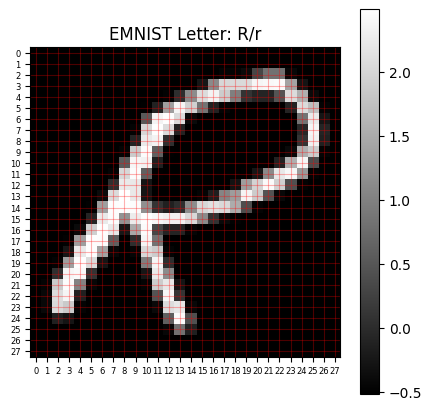

In [8]:
def correct_image_orientation(image):
    rotated = F.rotate(image, 90) # Rotate the image 90 degrees clockwise
    flipped = F.vflip(rotated) # Flip the image vertically
    return flipped

# Rotate the image and Reflect it
img_transformed = correct_image_orientation(img_tensor)

# Visualize the transformed image
helper_utils.visualize_image(img_transformed, label)

<a name='1.4'></a>
### 1.4 - Loading Data in Batches

Your neural network needs input in a structured, consistent format. To achieve that, you’ll use PyTorch’s `DataLoader` to organize your preprocessed letter images into batches—making training more efficient and easier to manage.

In this step, you’ll complete the `create_emnist_dataloaders` to set up `DataLoader` objects for both training and test data. These loaders will automatically handle batching and shuffling, ensuring that your model trains effectively and generalizes well.

<a name='ex1'></a>
### Exercise 1 - create_emnist_dataloaders

Implement the `create_emnist_dataloaders` function to create PyTorch `DataLoader` objects for the EMNIST training and testing datasets.

**Your task:**
* Create `train_dataloader` and `test_dataloader` using the `DataLoader` class from `torch.utils.data`. 
    * Define `suffle` accordingly to each dataset.
    * Use the `batch_size` parameter to set the number of samples per batch.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

**For `train_dataloader`:**
  * Use `shuffle=True` to ensure the training data is shuffled at every epoch.
  * Set `batch_size` to the given `batch_size` parameter.
  
**For `test_dataloader`:**
  * Use `shuffle=False` since you typically don't shuffle test data.
  * Set `batch_size` to the given `batch_size` parameter.
</details>

In [9]:
# GRADED FUNCTION: create_emnist_dataloaders

def create_emnist_dataloaders(train_dataset, test_dataset, batch_size=64):
    """
    Creates DataLoader objects for the EMNIST training and testing datasets.

    Args:
        train_dataset (torch.utils.data.Dataset): The training dataset.
        test_dataset (torch.utils.data.Dataset): The testing dataset.
        batch_size (int, optional): The batch size for the DataLoaders. Defaults to 64.

    Returns:
        tuple (torch.utils.data.DataLoader, torch.utils.data.DataLoader):
            A tuple containing the training and testing DataLoaders (train_loader, test_loader).
    """

    ### START CODE HERE ###

    # Create a DataLoader for the training dataset
    train_dataloader = DataLoader(
        # Pass in the train_dataset
        dataset=train_dataset,
        # Set batch_size
        batch_size=batch_size,
        # Set shuffle
        shuffle=True
    )  

    # Create a DataLoader for the testing dataset
    test_dataloader = DataLoader(
        # Pass in the test_dataset
        dataset=test_dataset,
        # Set batch_size
        batch_size=batch_size,
        # Set shuffle
        shuffle=False
    )  

    ### END CODE HERE ###

    # Return the created DataLoaders
    return train_dataloader, test_dataloader

Examine the contents of the resulting `DataLoader` objects. 
This will help you verify that the artifacts have been correctly organized into batches and that the shuffling has been applied to the training data.

In [10]:
train_loader, test_loader = create_emnist_dataloaders(train_dataset, test_dataset, batch_size=64)

print("--- Train Loader --- \n")
helper_utils.display_data_loader_contents(train_loader)
print("\n--- Test Loader --- \n")
helper_utils.display_data_loader_contents(test_loader)

--- Train Loader --- 

Total number of images in dataset: 124800
Total number of batches: 1950
--- Batch 1 ---
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])

--- Test Loader --- 

Total number of images in dataset: 20800
Total number of batches: 325
--- Batch 1 ---
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


#### Expected Output
```
--- Train Loader --- 

Total number of images in dataset: 124800
Total number of batches: 1950
--- Batch 1 ---
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])

--- Test Loader --- 

Total number of images in dataset: 20800
Total number of batches: 325
--- Batch 1 ---
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
```

In [11]:
# Test your code!
unittests.exercise_1(create_emnist_dataloaders)

 All tests passed!


<a name='2'></a>
## 2 - Building the Neural Network

Now that your data pipeline is ready, it’s time to build your neural network model.

In this step, you’ll define a model that can learn to recognize and classify handwritten letters from the EMNIST dataset. You’ll also set up the loss function and optimizer that the model will use during training.

<a name='ex2'></a>
### Exercise 2 - initialize_emnist_model

Implement the `initialize_emnist_model` function to create a PyTorch `Sequential` model for EMNIST classification.

**Your task:**

* **Define the Model Architecture**: 
  * Define a `model` using `nn.Sequential`.
  * The **first layer must** be a flatten layer (`nn.Flatten()`).
  * The middle layers, which you can design, **must only** consist of linear (`nn.Linear`) and ReLU (`nn.ReLU`) layers.
  * The middle layers **must not exceed** 5 layers in total.
  * The hidden unit size **must be less than or equal to** 256.
  * The **final layer must** be a linear layer (`nn.Linear`) mapping features to `num_classes` outputs.
  * The **total number of layers (including the first and final) must not exceed** 7.

* **Define the Loss Function**:
  * Define `loss_function` as **Cross Entropy Loss**.

* **Define the Optimizer**:
  * Define `optimizer` as **Adam** with a learning rate of 0.001. You should pass the model parameters (`model.parameters()`) to the optimizer.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
**For the Model:**
* Remember to list your layers inside the `nn.Sequential()` constructor, separated by commas.
* The `nn.Linear()` layer takes two main arguments: `in_features` and `out_features`. 
Ensure the `in_features` of one layer matches the `out_features` of the one before it.
* The correct order of layers is: **Flatten -> Linear -> ReLU -> Linear -> ReLU -> ... -> Linear**.
* The final layer should have `out_features` equal to `num_classes`, which is 26 for the EMNIST Letters dataset.

**For the Loss Function:**
* Use `nn.CrossEntropyLoss()` to define the loss function.

**For the Optimizer:**
* You will use `optim.Adam` as the optimizer. Its first argument should be the model parameters, which you can access using `model.parameters()`.
* The learning rate can be set by passing `lr=0.001` as a keyword argument to the optimizer.
</details>

In [12]:
# GRADED FUNCTION: initialize_emnist_model

def initialize_emnist_model(num_classes=26):
    """
    Initializes a sequential neural network model for EMNIST classification.

    Args:
        num_classes (int): The number of output classes. Defaults to 26.

    Returns:
        tuple: A tuple containing the model, loss function, and optimizer.
               (model, loss_function, optimizer)
    """

    torch.manual_seed(42)  # Set seed for reproducibility

    ### START CODE HERE ###

    # Define the neural network model using nn.Sequential
    model = nn.Sequential(
        # Flatten the input images
        nn.Flatten(),
        # Middle part should not have more than 5 layers. Only Linear and ReLU layers.
        # Note: Hidden layer units should not exceed 256
        nn.Linear(784, 256), # 28*28 = 784, because the images are 28x28 pixels, converting it to a 1D(1,784) array from a 2D(1,28,28) array
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        # Final Layer: SHOULD be Linear Layer
        # Output layer with shape nn.Linear(valid inputs to the layer, num_classes outputs)
        nn.Linear(128, num_classes),
    )

    # Define the loss function (Cross-Entropy Loss for multi-class classification)
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer (Adaptive Moment Estimation)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    ### END CODE HERE ###

    return model, loss_function, optimizer

Examine the model definition.
This will help you ensure that the model architecture, loss function, and optimizer are correctly configured.

In [13]:
your_model, loss_func, optimizer = initialize_emnist_model(num_classes=26)

print(f"Your model's architecture:\n\n{your_model}\n")
print(f"Your model's loss function: {loss_func}\n")
print(f"Your model's optimizer:\n\n{optimizer}\n")

Your model's architecture:

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)

Your model's loss function: CrossEntropyLoss()

Your model's optimizer:

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)



#### Expected Output (Approximately):
```
Your model's architecture:

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=26, bias=True)
)

Your model's loss function: CrossEntropyLoss()

Your model's optimizer:

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)`

In [14]:
# Test your code!
unittests.exercise_2(initialize_emnist_model)

 All tests passed!


<a name='3'></a>
## 3 - Training and evaluation of the Model

<a name='3.1'></a>
### 3.1 - Training the Model

The data pipeline is ready, and your model is built. Now it's time for **training**.

This is where all the previous steps come together—allowing your model to learn from the training data.
<a name='ex3'></a>
### Exercise 3 - train_epoch

Implement the `train_epoch` function to train a PyTorch model for one epoch and calculate the average loss and accuracy on the training set.

**Your task:**

* **Within the epoch training loop**:
    * Zero the gradients of the optimizer.
    * Fill `outputs` with the model's predictions for the current `inputs`.
    * Calculate the `loss` using the `loss_function` with `outputs` and `targets`.
    * Perform backpropagation with `loss.backward()` and update the model parameters using the `optimizer`.

  * **For the calculation of loss and accuracy**:
    * Obtain the current `loss_value` using `loss.item()` and accumulate it in `running_loss`.
    * Obtain the `predicted_indices` by taking the `argmax` along dimension 1 of the `outputs`.
    * Obtain the `correct_predictions` by comparing `predicted_indices` to `targets`.
    * Get `num_correct_in_batch` by summing the correct predictions in the batch from `correct_predictions`.
    * Update `num_correct_predictions` by adding `num_correct_in_batch`.
    * Get the batch_size from the targets by using `targets.size(0)`.
    * Add the current batch size to `total_predictions`.

* **After all batches:**
  * Calculate the average loss for the epoch by dividing `running_loss` by the number of batches.
  * Calculate the accuracy percentage for the epoch.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

* **Within the epoch training loop**:
  * Use `optimizer.zero_grad()` to zero the gradients.
  * Use `outputs = model(inputs)` to get the model's predictions.
  * Use `optimizer.step()` to update the model parameters after backpropagation.

* **For the calculation of loss and accuracy**:
  * Use `outputs.argmax(dim=1)` to get the predicted indices.
  * Use `predicted_indices.eq(targets)` to compare predicted indices to actual targets.
  * Use `correct_predictions.sum().item()` to get the number of correct predictions in the batch.

* **After all batches**:
  * Use `running_loss / len(train_loader)` to calculate the average loss for the epoch
  * Use `num_correct_predictions / total_predictions * 100` to calculate the accuracy percentage for the epoch.


</details>
  








In [15]:
def train_epoch(model, loss_function, optimizer, train_loader, device, verbose=True):
    """
    Trains the model for one epoch and calculates the average loss and accuracy.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        loss_function (nn.Module): The loss function used for training.
        optimizer (optim.Optimizer): The optimizer used for updating model parameters.
        train_loader (DataLoader): DataLoader for the training dataset, providing batches of data.
        device (torch.device): The device (CPU or CUDA) where the model and data will be moved.
        verbose (bool, optional): If True, prints the average loss and accuracy for the epoch. Defaults to True.

    Returns:
        tuple: A tuple containing:
            - nn.Module: The trained model after one epoch.
            - float: The average loss for the epoch.
            - float: The accuracy percentage for the epoch.

    Note:
        - The target labels in the `train_loader` (EMNIST letters) are 1-indexed and so the function adjusts them
          to 0-indexed before calculating the loss.
    """

    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    # Set the model to training mode
    model.train()
    # Initialize running loss to 0
    running_loss = 0.0
    # Initialize the number of correct predictions to 0
    num_correct_predictions = 0
    # Initialize the total number of predictions to 0
    total_predictions = 0

    # Iterate over the batches of data from the training DataLoader
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the inputs and targets to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Shift target labels down by 1 (adjusting for EMNIST letters dataset)
        targets = targets - 1

    ### START CODE HERE ###

        # Zero the gradients of the optimizer.
        optimizer.zero_grad()

        # Pass the inputs through the model to get the outputs.
        outputs = model(inputs)

        # Calculate the loss between the outputs and the targets.
        loss = loss_function(outputs, targets)

        # Perform backpropagation to calculate the gradients.
        
        loss.backward()

        # Update the model parameters using the optimizer.
        optimizer.step()

        # Loss 
        # Accumulate the loss value to running_loss
        loss_value = loss.item()
        # Add current loss value to the total running loss.
        running_loss += loss_value

        # Accuracy
        # Get the predicted indices (by taking the argmax along dimension 1 of the outputs).
        _, predicted_indices = outputs.max(1)

        # Compare predicted indices to actual targets
        correct_predictions = (predicted_indices==targets)

        # Sum of correct predictions in the current batch.
        num_correct_in_batch = correct_predictions.sum().item()
        
        # Add correct predictions to the total correct predictions.
        num_correct_predictions += num_correct_in_batch

        # Get the batch size from the targets and add it to total predictions.
        batch_size = targets.size(0)
        total_predictions += batch_size


    # Calculate the average loss for the epoch. 
    # Divide the running loss by the number (len of train loader) of batches.
    average_loss = running_loss / len(train_loader)

    # Calculate the accuracy percentage for the epoch. Multiply correct predictions by 100.
    accuracy_percentage = 100* num_correct_predictions/total_predictions

    ### END CODE HERE ###

    # Conditionally print based on verbose flag
    if verbose:
        print(
            f"Epoch Loss (Avg): {average_loss:.3f} | Epoch Acc: {accuracy_percentage:.2f}%"
        )

    # Return the trained model and average loss
    return model, average_loss

Observe the model's initial learning process.
You'll execute the function for a single epoch and verify that the model is indeed training as expected.

In [16]:
### This will take a few seconds to execute
model, loss_function, optimizer = initialize_emnist_model(num_classes=26)

model_one_train_epoch, _ = train_epoch(model=model, # model
                                       loss_function=loss_function, # loss_function
                                       optimizer=optimizer, # optimizer
                                       train_loader=train_loader, # train_loader
                                       device=DEVICE) # DEVICE

Epoch Loss (Avg): 0.600 | Epoch Acc: 81.51%


#### Expected Output (Approximately):
```
Epoch Loss (Avg): 0.602 | Epoch Acc: 81.40%
```

In [17]:
# Test your code!

### This will take a few seconds to execute
unittests.exercise_3(train_epoch, model, loss_function, optimizer, train_loader)

 All tests passed!


<a name='3.2'></a>
### 3.2 - Evaluation of the Model

After training your model, it’s time to see how well it performs on data it hasn’t seen before. Evaluating on unseen data helps you measure how well the model generalizes to new handwritten samples.

In this step, you’ll implement the `evaluate_model` function to assess your model’s performance on the test dataset. You’ll use **accuracy** as the evaluation metric to quantify how often the model’s predictions match the true labels.

<a name='ex4'></a>
### Exercise 4 - evaluate

Implement the `evaluate` function to evaluate a PyTorch model on a test dataset and calculate the average accuracy.

**Your task:**

* Disable gradient calculation using `torch.no_grad()` during evaluation.

* **For the loop over the batches in `test_loader`**:
    * Fill `outputs` with the model's predictions for the current `inputs`.
    * Obtain the `predicted_indices` by taking the `argmax` along dimension 1 of the `outputs`.
    * Obtain the `correct_predictions` by comparing `predicted_indices` to `targets`.
    * Get `num_correct_in_batch` by summing the correct predictions in the batch from `correct_predictions`.
    * Update `num_correct_predictions` by adding `num_correct_in_batch`.
    * Get the batch_size from the targets by using `targets.size(0)`.
    * Add the current batch size to `total_predictions`.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

* **For the loop over the batches in `test_loader`:**
  * Use `outputs = model(inputs)` to get the model's predictions.
  * Use `predicted_indices = outputs.argmax(dim=1)` to get the predicted indices.
  * Use `correct_predictions = predicted_indices.eq(targets)` to compare predicted indices to actual targets.
  * Use `num_correct_in_batch = correct_predictions.sum().item()` to get the number of correct predictions in the batch.
</details>

In [18]:
# GRADED FUNCTION: evaluate

def evaluate(model, test_loader, device, verbose=True):
    """
    Evaluates the model on the test dataset and returns the accuracy percentage.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        test_loader (DataLoader): DataLoader for the testing dataset.
        device (torch.device): The device to use (CPU or CUDA).
        verbose (bool, optional): If True, prints the test accuracy. Defaults to True.

    Returns:
        float: The accuracy percentage of the model on the test dataset.

    Note:
        - The target labels in the `test_loader` (EMNIST letters) are 1-indexed and so the function adjusts them 
          to 0-indexed before calculating the accuracy.
    """
    
    # Set the model to evaluate mode
    model.eval()
    # Initialize the number of correct predictions to 0
    num_correct_predictions = 0
    # Initialize the total number of predictions to 0
    total_predictions = 0 

    ### START CODE HERE ###
    
    # Use torch.no_grad() context to disable gradient calculations during evaluation.
    with torch.no_grad():

    ### END CODE HERE ###
        
        # Iterate over the batches of data from the test DataLoader
        for inputs, targets in test_loader:
            # Move the inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Shift target labels down by 1 (adjusting for EMNIST letters dataset)
            targets = targets - 1

        ### START CODE HERE ###

            # Pass the inputs through the model to get the outputs.
            outputs = model(inputs)

            # Get the predicted indices (by taking the argmax along dimension 1 of the outputs).
            _,predicted_indices = torch.max(outputs.data, 1)

            # Compare predicted indices to actual targets
            correct_predictions = (predicted_indices == targets)        
            
            # Sum of correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            
            # Add correct predictions to the total correct predictions.
            num_correct_predictions += num_correct_in_batch

            # Get the batch size from the targets and add it to total predictions.
            batch_size = targets.size(0)
            total_predictions += batch_size

        ### END CODE HERE ###
        
        # Calculate the accuracy percentage. Multiply correct predictions by 100.
        accuracy_percentage = (num_correct_predictions / total_predictions) * 100

    if verbose:  # Conditionally print based on verbose flag
        print((f'Test Accuracy: {accuracy_percentage:.2f}%'))

    return accuracy_percentage

To verify that your model is working as intended, start by evaluating it on the test dataset. This step confirms that your model has learned meaningful patterns from the training data and that your evaluation function is performing correctly.

In [19]:
model_evaluate = evaluate(model, test_loader, DEVICE)

Test Accuracy: 89.92%


 #### Expected Output (Approximately):

 ```

 Test Accuracy: 87.59%

 ```

In [20]:
# Test your code!
unittests.exercise_4(evaluate, model, test_loader)

 All tests passed!


<a name='3.3'></a>
### 3.3 - Putting it all together

Now that you’ve implemented both the training and evaluation functions, it’s time to put everything together.
In this step, you’ll use the previously defined `train_epoch` and `evaluate` functions to create a complete training and evaluation loop.

<a name='ex5'></a>
### Exercise 5 - train_and_evaluate

Implement the `train_and_evaluate` function to train and evaluate a PyTorch model for a specified number of epochs.

**Your task:**

For each epoch in the range of `num_epochs`:

* Train the model for that epoch using `train_epoch`. 
Pass the `model`, `train_loader`, `loss_function`, `optimizer` and `device` as arguments.

* Evaluate the model using the `evaluate` function.
Pass the `model`, `test_loader` and `device` as arguments.

In [21]:
# GRADED FUNCTION: training_loop

def train_and_evaluate(
    model, train_loader, test_loader, num_epochs, loss_function, optimizer, device
):
    """
    Trains and evaluates the model for the specified number of epochs.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the testing dataset.
        num_epochs (int): The number of epochs to train for.
        loss_function (nn.Module): The loss function used for training.
        optimizer (optim.Optimizer): The optimizer used for updating model parameters.
        device (torch.device): The device to use (CPU or CUDA).

    Returns:
        nn.Module: The trained model.
    """

    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch+1}")

        ### START CODE HERE ###
        # Train the model for one epoch using the train_epoch function.
        trained_model, _ = train_epoch(model=model, # model
                                       loss_function=loss_function, # loss_function
                                       optimizer=optimizer, # optimizer
                                       train_loader=train_loader, # train_loader
                                       device=device)

        # Evaluate the trained model on the test dataset using the evaluate function.
        accuracy = evaluate(model, test_loader, device)

        ### END CODE HERE ###

    return trained_model

#### Train Your Model

That is it! You have successfully implemented the training and evaluation functions for your model. It is now time to train your model on the EMNIST dataset and evaluate its performance.
 
 Feel free to set the `num_epochs` to a value of your choice—just make sure it’s 15 or less to keep training manageable.

In [22]:
# EDITABLE CELL:

# Set the number of training epochs. Don't set more than 15
num_epochs = 10

In [23]:
### This might take a minute or so to execute

if num_epochs > 15 or num_epochs < 1:
    print(f"\033[91mSet num_epochs between 1 and 15 (inclusive).")

else:
    # Initialize the EMNIST model, loss function, and optimizer
    emnist_model, loss_function, optimizer = initialize_emnist_model(num_classes=26)
    
    # Train and evaluate the model for the specified number of epochs
    trained_model = train_and_evaluate(
        model=emnist_model,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        loss_function=loss_function,
        optimizer=optimizer,
        device=DEVICE
    )


Epoch: 1
Epoch Loss (Avg): 0.600 | Epoch Acc: 81.51%
Test Accuracy: 87.73%

Epoch: 2
Epoch Loss (Avg): 0.326 | Epoch Acc: 89.41%
Test Accuracy: 89.48%

Epoch: 3
Epoch Loss (Avg): 0.273 | Epoch Acc: 90.90%
Test Accuracy: 89.91%

Epoch: 4
Epoch Loss (Avg): 0.240 | Epoch Acc: 91.78%
Test Accuracy: 89.59%

Epoch: 5
Epoch Loss (Avg): 0.215 | Epoch Acc: 92.54%
Test Accuracy: 90.56%

Epoch: 6
Epoch Loss (Avg): 0.195 | Epoch Acc: 93.03%
Test Accuracy: 90.35%

Epoch: 7
Epoch Loss (Avg): 0.180 | Epoch Acc: 93.57%
Test Accuracy: 90.84%

Epoch: 8
Epoch Loss (Avg): 0.169 | Epoch Acc: 93.87%
Test Accuracy: 90.24%

Epoch: 9
Epoch Loss (Avg): 0.160 | Epoch Acc: 94.09%
Test Accuracy: 90.77%

Epoch: 10
Epoch Loss (Avg): 0.149 | Epoch Acc: 94.48%
Test Accuracy: 90.37%


#### Expected Output (Approximately for 10 Epochs):
```
Epoch: 1
Epoch Loss (Avg): 0.600 | Epoch Acc: 81.48%
Test Accuracy: 87.25%

Epoch: 2
Epoch Loss (Avg): 0.328 | Epoch Acc: 89.38%
Test Accuracy: 89.60%

Epoch: 3
Epoch Loss (Avg): 0.272 | Epoch Acc: 90.88%
Test Accuracy: 89.92%

Epoch: 4
Epoch Loss (Avg): 0.241 | Epoch Acc: 91.76%
Test Accuracy: 89.86%

Epoch: 5
Epoch Loss (Avg): 0.215 | Epoch Acc: 92.59%
Test Accuracy: 90.70%

Epoch: 6
Epoch Loss (Avg): 0.197 | Epoch Acc: 92.99%
Test Accuracy: 90.46%

Epoch: 7
Epoch Loss (Avg): 0.181 | Epoch Acc: 93.47%
Test Accuracy: 90.60%

Epoch: 8
Epoch Loss (Avg): 0.169 | Epoch Acc: 93.75%
Test Accuracy: 90.39%

Epoch: 9
Epoch Loss (Avg): 0.160 | Epoch Acc: 94.13%
Test Accuracy: 90.47%

Epoch: 10
Epoch Loss (Avg): 0.151 | Epoch Acc: 94.40%
Test Accuracy: 90.57%
```

After training, it's time to evaluate its performance on the test dataset.
You'll evaluate its accuracy *on each individual letter class* to identify any potential strengths or weaknesses in its analysis.

In [24]:
# Evaluate the trained model's performance on each letter class
class_accuracies = helper_utils.evaluate_per_class(trained_model, test_loader, DEVICE)

# Print the accuracy for each letter class
for letter, accuracy in class_accuracies.items():
    print(f"Accuracy for {letter}: {(accuracy*100):.2f} %")

Accuracy for A: 88.00 %
Accuracy for B: 92.12 %
Accuracy for C: 91.62 %
Accuracy for D: 92.62 %
Accuracy for E: 93.50 %
Accuracy for F: 93.12 %
Accuracy for G: 76.62 %
Accuracy for H: 89.88 %
Accuracy for I: 78.00 %
Accuracy for J: 92.62 %
Accuracy for K: 88.88 %
Accuracy for L: 71.62 %
Accuracy for M: 95.25 %
Accuracy for N: 93.50 %
Accuracy for O: 95.25 %
Accuracy for P: 96.25 %
Accuracy for Q: 80.25 %
Accuracy for R: 91.50 %
Accuracy for S: 97.50 %
Accuracy for T: 93.75 %
Accuracy for U: 93.50 %
Accuracy for V: 90.25 %
Accuracy for W: 95.62 %
Accuracy for X: 96.00 %
Accuracy for Y: 85.38 %
Accuracy for Z: 96.88 %


In [25]:
# Test your code!
unittests.exercise_5(class_accuracies)

 All tests passed!


 #### Save your Trained Model

 <p style="background-color:#ffe6f0; color:#282828; padding:15px; border-width:3px; border-color:#d8b2c2; border-style:solid; border-radius:6px">
   🚨&nbsp;<b>IMPORTANT:</b> Please ensure the test in the cell above has passed successfully before proceeding. The following cell will save your trained model, which is essential for grading. This saved model, along with your assignment notebook, will be used in the overall grading of your assignment when you submit it. Failure to run the next cell will prevent your model from being saved, resulting in an error during assignment submission.<br><br>
   🔄&nbsp;<b>Note:</b> You can run this cell multiple times to save your model. Each run will overwrite the previously saved version.

 </p>

In [26]:
### Run this cell to save your trained model
helper_utils.save_student_model(model=trained_model, filename='trained_student_model.pth')

Model saved to trained_student_model.pth


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-fundamentals/560).

---

<a name='4'></a>
## 4- Decoding the Secret Message

You now have all the tools you need to decode the secret message.

First, load the handwritten message images using `helper_utils.load_hidden_message_images`.
Then, use your trained model to predict each letter and reconstruct the words in the message.

In [27]:
# get the images of the secret message
message_imgs = helper_utils.load_hidden_message_images()

Now you will implement the `decode_word_imgs` function to decode a list of word images into a string using the trained model.
This function works similarly to `evaluate_model`, but instead of computing accuracy, it collects the model’s predicted characters and combines them to form words.

In [28]:
def decode_word_imgs(word_imgs, model, device):
    # put the model in eval mode
    model.eval()


    decoded_chars = []
    
    with torch.no_grad():
        # iterate through each character image in the word
        for char_img in word_imgs:
            # add batch dimension and move to device
            char_img = char_img.unsqueeze(0).to(device)

            # predict the character with the model
            output = model(char_img)
            _, predicted = output.max(1)
            predicted_label = predicted.item()

            # match the predicted label to the corresponding character
            lowercase_char = chr(ord("a") + predicted_label)

            # append the character to the decoded_chars list
            decoded_chars.append(f"{lowercase_char}")

    # join the characters to form the decoded word
    decoded_word = "".join(decoded_chars)
    return decoded_word

You are finally ready to decode the secret message! 

In [29]:
for sentence_imgs in message_imgs:
    decoded_sentence = []

    for word_imgs in sentence_imgs:
        decoded_word = decode_word_imgs(word_imgs, trained_model, DEVICE)
        decoded_sentence.append(decoded_word)

    print(" ".join(decoded_sentence))

dear iaurencr
hope the pytorch course is golng weli
do not forget to keep tne iabs interesting and engaging
maybe couid have the students try to decode my messx handwriting
that might be a bit too challengihg though
i am lmpressed you are able td read this


Observe the decoded message and see if you can read Andrew Ng’s handwritten note.

Most letters should be correctly identified, though a few minor mistakes may appear—for example, the letter `d` being read as `a`, `l` as `i`, or `n` as `m` or `h`. These errors likely occur because of how similar the letters look when written quickly or unevenly.
Indeed, given the `class_accuracies` observed during the evaluation phase (subsection 3.3), it is understandable that some letters may be misinterpreted.

An interesting challenge would be to refine your model to better distinguish between such closely shaped characters!

<details>
<summary><b><font color="green">Original Message</font></b></summary>

```
Dear Laurence,
Hope the PyTorch course is going well.
Do not forget to keep the labs interesting and engaging.
Maybe you could have the students try to decode my messy handwriting.
That might be a bit too challenging though.
I am impressed you are able to read this.
```
</details> 

<a name='conclusion'></a>
## Conclusion

Congratulations, you’ve completed the assignment and built your own letter-recognizing neural network!

You’ve worked through every key stage of the deep learning workflow. You began by acquiring and preprocessing the EMNIST “Letters” dataset, calculating its mean and standard deviation, correcting image orientations, and normalizing pixel values. You then organized your data efficiently using PyTorch DataLoaders.

Next, you designed and initialized a multi-layer neural network, selected an appropriate loss function and optimizer, and brought your model to life by implementing the training and evaluation loops. You watched its performance improve over epochs and finally put it to the test by decoding a secret message.

The skills you’ve practiced here, from handling real image data and applying essential preprocessing steps to building, training, and evaluating neural networks, are foundational. You now have a solid grounding in PyTorch for tackling more advanced architectures, including convolutional neural networks for complex image classification tasks. Well done!

 <a name='help'></a>

 ## Need more help with the model's architecture?



 Run the following cell to see an architecture that works well for the problem at hand:

In [30]:
# WE STRONGLY RECOMMEND YOU TO TRY YOUR OWN ARCHITECTURES FIRST
# AND ONLY RUN THIS CELL IF YOU WISH TO SEE AN ANSWER
import base64

encoded_answer = "LSBBIEZsYXR0ZW4gbGF5ZXIKLSBBIExpbmVhciBsYXllciB3aXRoIDc4NCBpbnB1dCBmZWF0dXJlcyBhbmQgMjU2IG91dHB1dCBmZWF0dXJlcwotIEEgUmVMVSBhY3RpdmF0aW9uIGZ1bmN0aW9uCi0gQSBMaW5lYXIgbGF5ZXIgd2l0aCAyNTYgaW5wdXQgZmVhdHVyZXMgYW5kIDEyOCBvdXRwdXQgZmVhdHVyZXMKLSBBIFJlTFUgYWN0aXZhdGlvbiBmdW5jdGlvbgotIEEgTGluZWFyIGxheWVyIHdpdGggMTI4IGlucHV0IGZlYXR1cmVzIGFuZCBudW1fY2xhc3Nlcz0yNiBvdXRwdXQgZmVhdHVyZXMKLSBUcmFpbiB0aGUgbW9kZWwgZm9yIDEwIG9yIG1vcmUgZXBvY2hz"
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)

- A Flatten layer
- A Linear layer with 784 input features and 256 output features
- A ReLU activation function
- A Linear layer with 256 input features and 128 output features
- A ReLU activation function
- A Linear layer with 128 input features and num_classes=26 output features
- Train the model for 10 or more epochs
